In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sympy as smp
from tqdm import tqdm
from sympy import Symbol, symbols
from pathlib import Path
import centrex_TlF as centrex
import matplotlib.pyplot as plt
from julia import Main

In [2]:
syspars = centrex.states.SystemParameters(
    nprocs  = 7,
    Γ       = 2*np.pi*1.56e6,
    ground  = [centrex.states.QuantumSelector(J=1, electronic = 'X'),
               centrex.states.QuantumSelector(J=3, electronic = 'X')],
    excited = centrex.states.QuantumSelector(J=1, F=1, F1=1/2, P=+1, electronic = 'B')
)

In [3]:
odepars = centrex.lindblad.odeParameters(
    Ωl = "Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0     = 1*syspars.Γ,    # Rabi frequency of the laser [rad/s]
    δl      = 0,              # detuning of the laser [rad/s]
    
    # laser phase modulation
    ωphase = syspars.Γ,       # laser phase modulation frequency [rad/s]
    β      = 3.8,             # laser phase modulation depth [rad]

    # laser polarization switching
    ωp = 2*np.pi*1.56e6,           # polarization switching frequency [rad/s]
    φp = 0.0,                 # polarization switching phase [rad]
    Pl  = "sin(ωp*t + φp)",
    Plz = "Pl>0",
    Plx = "Pl<=0",
    
    # molecules
    y0 = 0,                   # molecule start y position [m]
    vz = 184,                 # longitudinal molecular velocity [m/s]
    vy = 0,                   # molecule vy [m/s]
)

# notice the optional declaration of the main states for the ground and excited states, this will be the
# main transition used if entered, otherwise a main transition is automatically chosen.
transitions = [
    centrex.couplings.TransitionSelector(
        ground               = 1*centrex.states.generate_coupled_states_ground_X(syspars.ground[0]),
        excited              = 1*centrex.states.generate_coupled_states_excited_B(syspars.excited),
        polarizations        = [[1,0,0], [0,0,1]],
        polarization_symbols = symbols("Plx     Plz"),
        Ω                    = Symbol('Ωl', complex = True),
        δ                    = Symbol('δl'),
        description          = "laser transition",
#         ground_main          = 1*centrex.states.generate_coupled_states_ground_X(syspars.ground[0])[-3],
#         excited_main         = 1*centrex.states.generate_coupled_states_excited_B(syspars.excited)[-1]
    )
]

In [4]:
# Note qn_compact, this takes a QuantumSelector object which specifies a set of quantum numbers to compact into
# a single state, in this case the J=3 hyperfine levels. Since J=3 is just a decay channel for this system we
# don't care which specific hyperfine levels it decays into.
obe_system = centrex.lindblad.setup_OBE_system_julia(syspars, odepars, transitions, verbose=True, full_output=True, 
                                                     qn_compact=centrex.states.QuantumSelector(J=3, electronic = 'X'))

INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices


INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations
INFO:centrex_TlF.lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF.lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF.lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 7 cores
INFO:centrex_TlF.lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and parameters in Julia


Initialized Julia with 7 processes


In [5]:
obe_system.H_symbolic

Matrix([
[         -139730.395645142,                          0,                          0,                          0,                         0,                         0,                          0,                          0,                          0,                          0,                         0,                         0,               0, -0.510649425347001*Plx*Ωl,  0.722245016436676*Plz*Ωl,  0.510759271470996*Plx*Ωl],
[                         0,           10.6988372802734,                          0,                          0,                         0,                         0,                          0,                          0,                          0,                          0,                         0,                         0,               0, -0.707027620108216*Plz*Ωl, -0.499940438424143*Plx*Ωl,                         0],
[                         0,                          0,                          0,                          0,               

In [6]:
odepars.Ωl0 = 1*syspars.Γ
odepars.ωphase = 0
odepars.ωp = 1*syspars.Γ

In [7]:
ρ = centrex.utils.generate_population_states(centrex.states.QuantumSelector(J=1, electronic = 'X').get_indices(obe_system.QN), len(obe_system.QN))
t_array, results = centrex.lindblad.do_simulation_single(odepars, (0,400e-6), ρ)

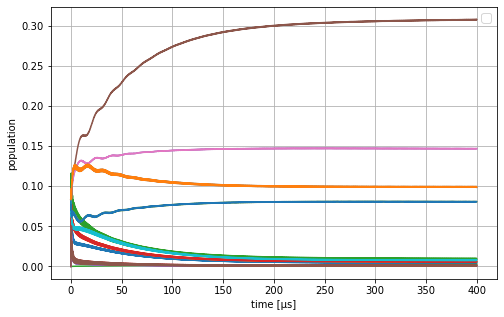

In [8]:
fig, ax = plt.subplots(figsize = (8,5)) 
ax.plot(t_array*1e6, results.T);
ax.set_xlabel('time [μs]')
ax.legend(fontsize = 12)
ax.set_ylabel('population')
ax.grid(True)

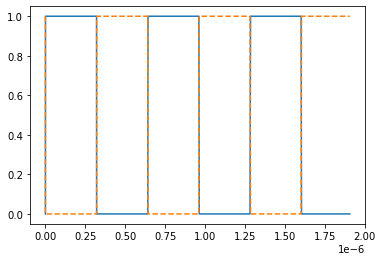

In [9]:
zpol = odepars.get_parameter_evolution(t_array, 'Plz').astype(bool)
xpol = odepars.get_parameter_evolution(t_array, 'Plx').astype(bool)
plt.plot(t_array[:100], zpol[:100])
plt.plot(t_array[:100], xpol[:100], '--')

In [10]:
ls = [f"F$_1$={qn.find_largest_component().F1}, F={qn.find_largest_component().F:.0f}, mF={qn.find_largest_component().mF}" if qn.find_largest_component().J == 1 else f"J={qn.find_largest_component().J}"for qn in obe_system.QN]
ls

['F$_1$=0.5, F=0, mF=-0.0',
 'F$_1$=0.5, F=1, mF=-1.0',
 'F$_1$=0.5, F=1, mF=0.0',
 'F$_1$=0.5, F=1, mF=1.0',
 'F$_1$=1.5, F=1, mF=-1.0',
 'F$_1$=1.5, F=1, mF=0.0',
 'F$_1$=1.5, F=1, mF=1.0',
 'F$_1$=1.5, F=2, mF=-2.0',
 'F$_1$=1.5, F=2, mF=-1.0',
 'F$_1$=1.5, F=2, mF=0.0',
 'F$_1$=1.5, F=2, mF=1.0',
 'F$_1$=1.5, F=2, mF=2.0',
 'J=3',
 'F$_1$=0.5, F=1, mF=-1.0',
 'F$_1$=0.5, F=1, mF=0.0',
 'F$_1$=0.5, F=1, mF=1.0']

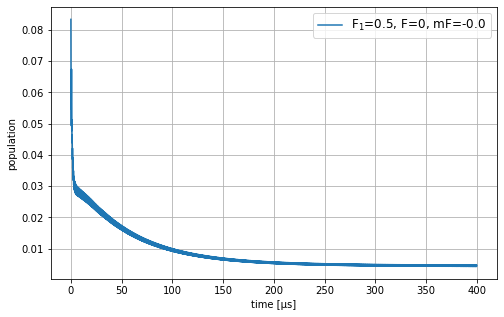

In [11]:
fig, ax = plt.subplots(figsize = (8,5))
for r,l in zip(results,ls):
    if 'F=0,' in l:
        ax.plot(t_array*1e6, r, label = l);
ax.set_xlabel('time [μs]')
ax.legend(fontsize = 12)
ax.set_ylabel('population')
ax.grid(True)
fig.savefig("F_0__mF_0.png")

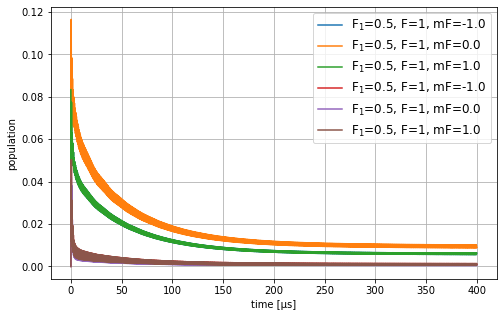

In [12]:
fig, ax = plt.subplots(figsize = (8,5))
for r,l in zip(results,ls):
    if 'F$_1$=0.5, F=1,' in l:
        ax.plot(t_array*1e6, r, label = l);
ax.set_xlabel('time [μs]')
ax.legend(fontsize = 12)
ax.set_ylabel('population')
ax.grid(True)
fig.savefig("F1_05_F_1.png")

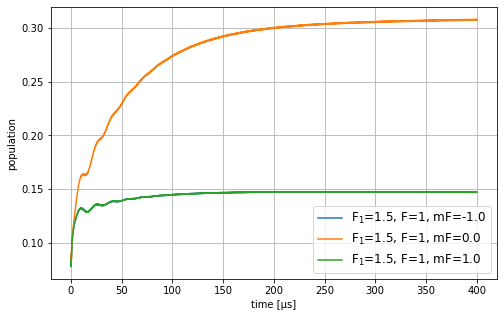

In [13]:
fig, ax = plt.subplots(figsize = (8,5))
for r,l in zip(results[:-3],ls):
    if 'F$_1$=1.5, F=1,' in l:
        ax.plot(t_array*1e6, r, label = l);
ax.set_xlabel('time [μs]')
ax.legend(fontsize = 12)
ax.set_ylabel('population')
ax.grid(True)
fig.savefig("F1_15_F_1.png")

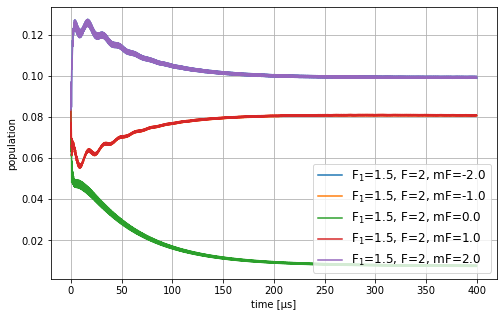

In [14]:
fig, ax = plt.subplots(figsize = (8,5))
for r,l in zip(results[:-3],ls):
    if 'F$_1$=1.5, F=2,' in l:
        ax.plot(t_array*1e6, r, label = l);
ax.set_xlabel('time [μs]')
ax.legend(fontsize = 12)
ax.set_ylabel('population')
ax.grid(True)
fig.savefig("F1_15_F_2.png")

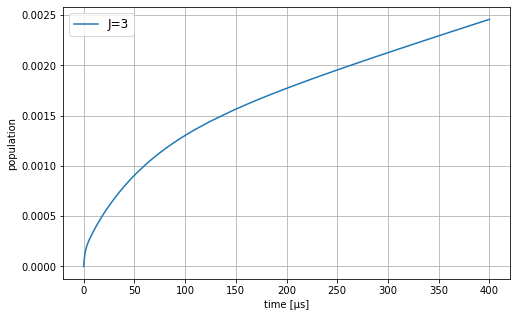

In [15]:
fig, ax = plt.subplots(figsize = (8,5))
for r,l in zip(results[:-3],ls):
    if 'J=3' in l:
        ax.plot(t_array*1e6, r, label = l);
ax.set_xlabel('time [μs]')
ax.legend(fontsize = 12)
ax.set_ylabel('population')
ax.grid(True)
fig.savefig("J_3.png")

In [16]:
Plz, Plx, Ωl, δl, Ωlc = list(obe_system.H_symbolic.free_symbols)

In [17]:
valsz, vecsz = np.linalg.eig(np.array(obe_system.H_symbolic.subs([(Plz,1),(Plx,0),(δl,0),(Ωl,odepars.Ωl0),(Ωlc,odepars.Ωl0)]), dtype = complex))
valsx, vecsx = np.linalg.eig(np.array(obe_system.H_symbolic.subs([(Plx,1),(Plz,0),(δl,0),(Ωl,odepars.Ωl0),(Ωlc,odepars.Ωl0)]), dtype = complex))

In [39]:
obe_system.H_symbolic.subs([(Plz,1),(Plx,0),(δl,0),(Ωl,odepars.Ωl0),(Ωlc,odepars.Ωl0)])

Matrix([
[-139730.395645142,                 0, 0,                 0,                0,                0,                 0,                0,                0,                0,                0,                0,               0,                 0, 69389456728211.6,                 0],
[                0,  10.6988372802734, 0,                 0,                0,                0,                 0,                0,                0,                0,                0,                0,               0, -67927450289926.5,                0,                 0],
[                0,                 0, 0,                 0,                0,                0,                 0,                0,                0,                0,                0,                0,               0,                 0,                0,                 0],
[                0,                 0, 0, -10.7021331787109,                0,                0,                 0,                0,                0,

In [19]:
cor = np.zeros(obe_system.H_symbolic.shape, dtype = complex)
for i,vz in enumerate(vecsz.T):
    for j,vx in enumerate(vecsx.T):
        cor[i,j] = (vz[:-3]@vx[:-3])

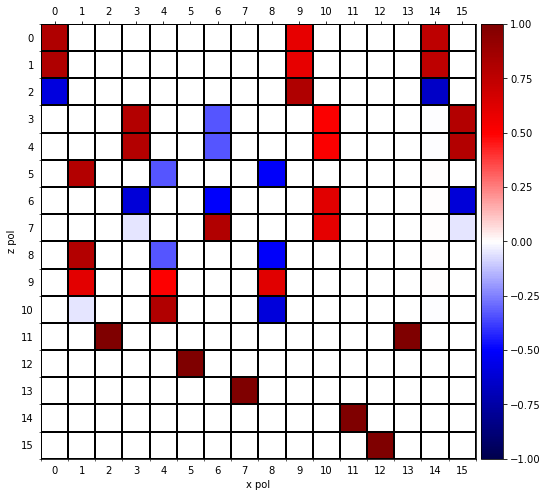

In [20]:
tolerance = 1e-5
import matplotlib as mpl
cmap = mpl.cm.get_cmap("seismic")

tmp = cor.copy()
tmp[tmp == 0] = np.nan
tmp[np.abs(tmp) < tolerance] = np.nan

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(tmp.real, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(cax, fraction=0.046, pad=0.01)

ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                 bottom=False, top=True, left=False, right=False)

ax.set_xlabel('x pol')
ax.set_ylabel('z pol')

ax.set_xticks(np.arange(0, len(vecsx), 1))
ax.set_yticks(np.arange(0, len(vecsx), 1))

ax.set_xticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2);

In [21]:
transformed = np.zeros(results.shape)
transformed[:,zpol] = np.diagonal((np.linalg.inv(vecsz)@(np.array(Main.eval("sol[:]"))[zpol]@vecsz)).real, axis1 = 1, axis2 = 2).T
transformed[:,xpol] = np.diagonal((np.linalg.inv(vecsx)@(np.array(Main.eval("sol[:]"))[xpol]@vecsx)).real, axis1 = 1, axis2 = 2).T

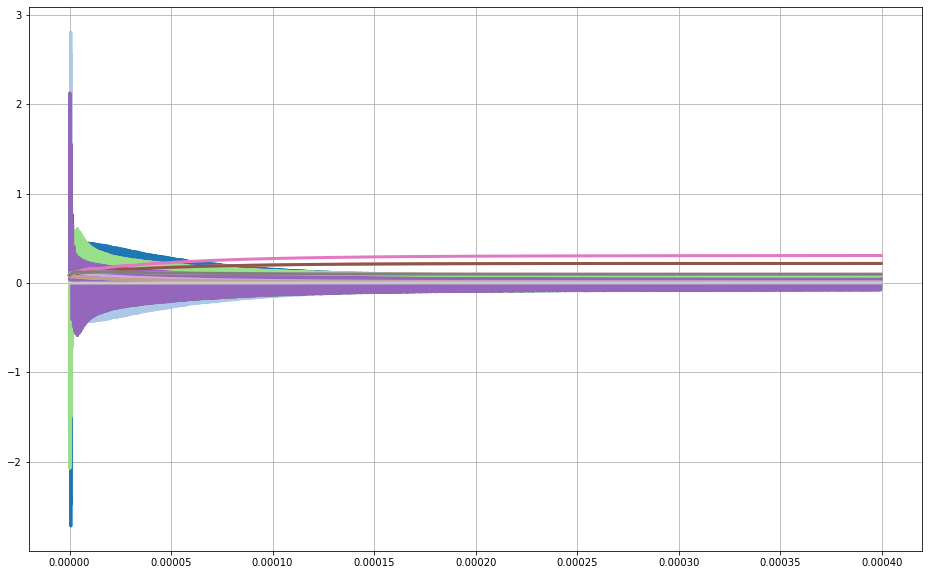

In [22]:
cmap = mpl.cm.get_cmap("tab20")
fig, ax = plt.subplots(figsize = (16,10))
for idx in range(16):
    ax.plot(t_array[zpol], transformed.T[zpol][:,idx], color = cmap(idx), lw = 3);
    #ax.plot(t_array[xpol], transformed.T[xpol][:,idx], '--', color = cmap(idx), lw = 3)
ax.grid(True);

In [23]:
tolerance = 1e-5
tmp = vecsz.copy()
tmp[np.abs(tmp) < tolerance] = 0
darkz = np.nansum(tmp[-3:,:]**2, axis = 0) < tolerance

In [ ]:
tolerance = 1e-5
tmp = vecsz.copy()
tmp[np.abs(tmp) < tolerance] = 0
darkz = np.nansum(tmp[-3:,:]**2, axis = 0) < tolerance

In [24]:
tolerance = 1e-5
tmp = vecsx.copy()
tmp[np.abs(tmp) < tolerance] = 0
darkx = np.nansum(tmp[-3:,:]**2, axis = 0) < tolerance

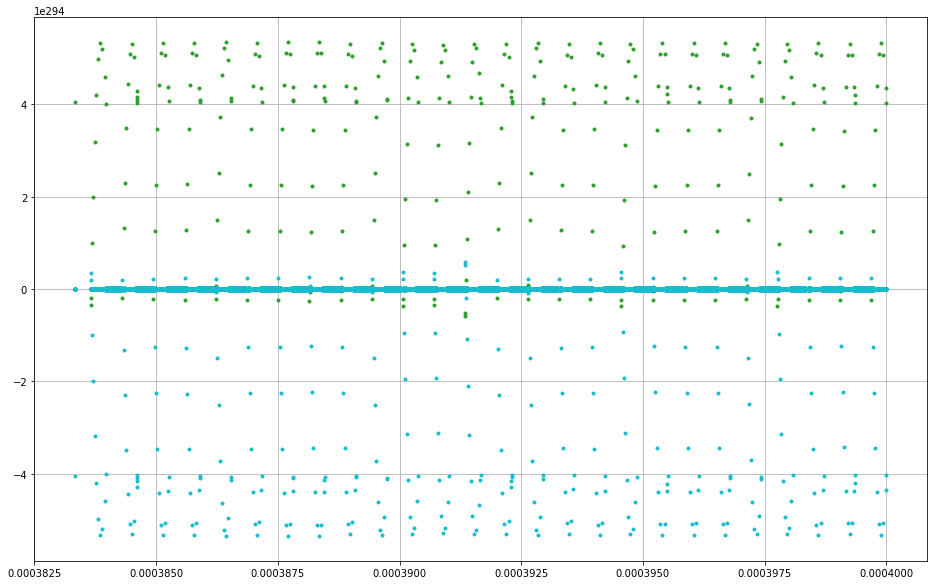

In [25]:
sl = np.s_[-300:]

cmap = mpl.cm.get_cmap("tab10")

fig, ax = plt.subplots(figsize = (16,10))
for idx in range(darkx.sum()):
    ax.plot(t_array[zpol][sl], (transformed[:,zpol][darkz,:]).T[sl][:,idx], 'x', lw = 3, label = 'z pol', color = cmap(idx))
    ax.plot(t_array[xpol][sl], (transformed[:,xpol][darkx,:]).T[sl][:,idx], '.', lw = 3, label = 'x pol', color = cmap(idx))
ax.grid(True);

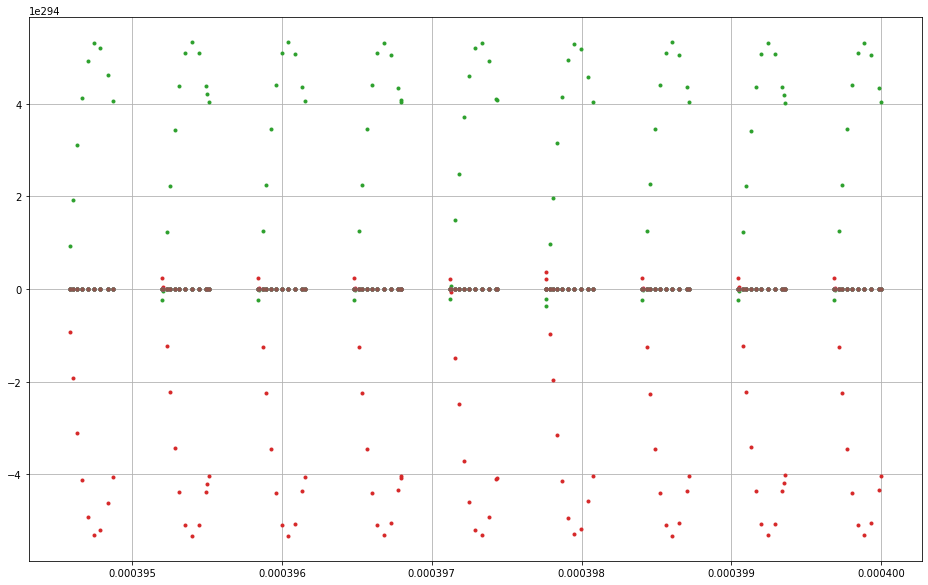

In [26]:
sl = np.s_[-100:]

fig, ax = plt.subplots(figsize = (16,10))
ax.plot(t_array[xpol][sl], (transformed[:,xpol][darkx,:]).T[sl], '.', lw = 3, label = 'x pol')
ax.grid(True);

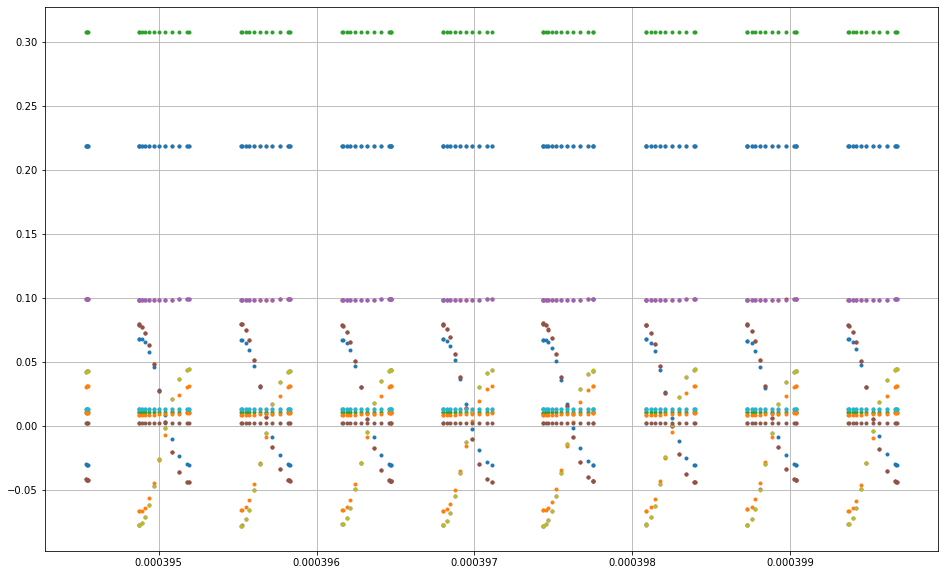

In [28]:
sl = np.s_[-100:]

fig, ax = plt.subplots(figsize = (16,10))
ax.plot(t_array[zpol][sl], (transformed[:,zpol][darkz,:]).T[sl], '.', lw = 3)
ax.grid(True);

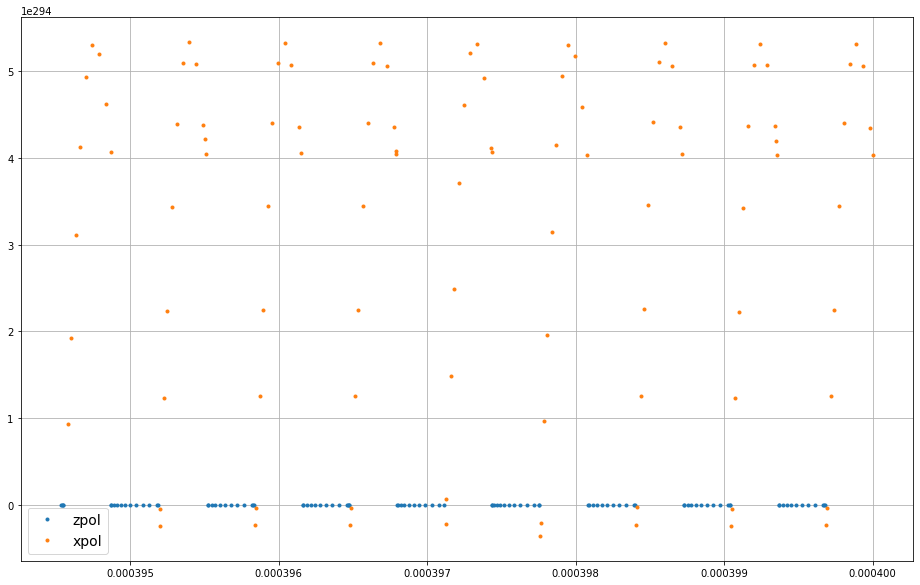

In [29]:
sl = np.s_[-100:]
idz = 2
idx = 2
fig, ax = plt.subplots(figsize = (16,10))
ax.plot(t_array[zpol][sl], transformed.T[zpol][:,idz][sl], '.', lw = 3, label = 'zpol')
ax.plot(t_array[xpol][sl], transformed.T[xpol][:,idx][sl], '.', lw = 3, label = 'xpol')
ax.legend(fontsize = 14)
ax.grid(True);

In [30]:
labels = [f"F$_1$={qn.F1}, F={int(qn.F)}, mF={int(qn.mF)}" if qn.J != 3 else "J=3" for qn in [qn.find_largest_component() for qn in  obe_system.QN]]

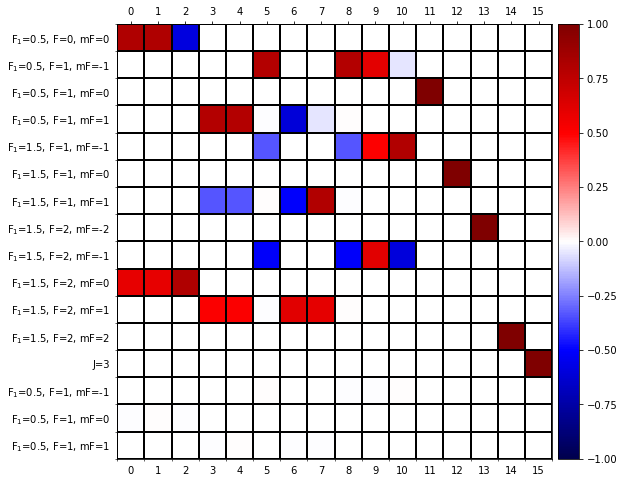

In [37]:
tolerance = 1e-10
import matplotlib as mpl
cmap = mpl.cm.get_cmap("seismic")

tmp = vecsz.copy()
tmp[tmp == 0] = np.nan
tmp[np.abs(tmp) < tolerance] = np.nan

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(tmp.real, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(cax, fraction=0.046, pad=0.01)

ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                 bottom=False, top=True, left=False, right=False)

ax.set_xticks(np.arange(0, len(vecsx), 1))
ax.set_yticks(np.arange(0, len(vecsx), 1))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2);

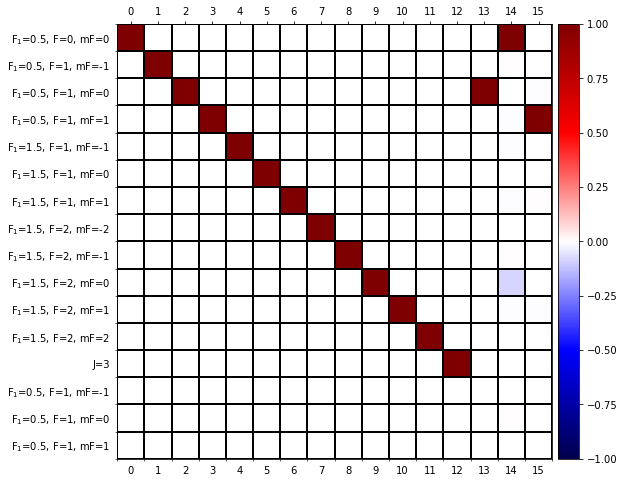

In [38]:
tolerance = 1e-10
import matplotlib as mpl
cmap = mpl.cm.get_cmap("seismic")

tmp = vecsx.copy()
tmp[tmp == 0] = np.nan
tmp[np.abs(tmp) < tolerance] = np.nan

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(tmp.real, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(cax, fraction=0.046, pad=0.01)

ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                 bottom=False, top=True, left=False, right=False)

ax.set_xticks(np.arange(0, len(vecsx), 1))
ax.set_yticks(np.arange(0, len(vecsx), 1))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(vecsx), 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2);

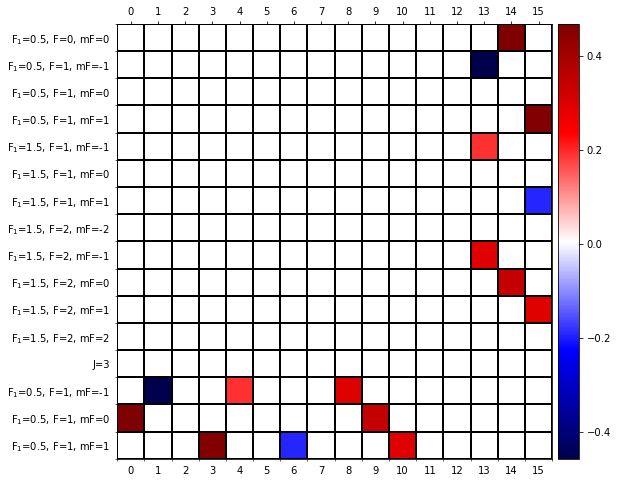

In [33]:
tmp = obe_system.couplings[0]['fields'][1]['field']
tmp[tmp == 0] = np.nan
tmp = np.delete(tmp, np.s_[13:40], axis = 0)
tmp = np.delete(tmp, np.s_[13:40], axis = 1)

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(tmp.real, cmap = cmap)
fig.colorbar(cax, fraction=0.046, pad=0.01)

ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                 bottom=False, top=True, left=False, right=False)

ax.set_xticks(np.arange(0, 16, 1))
ax.set_yticks(np.arange(0, 16, 1))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(-.5, 16, 1), minor=True)
ax.set_yticks(np.arange(-.5, 16, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2);

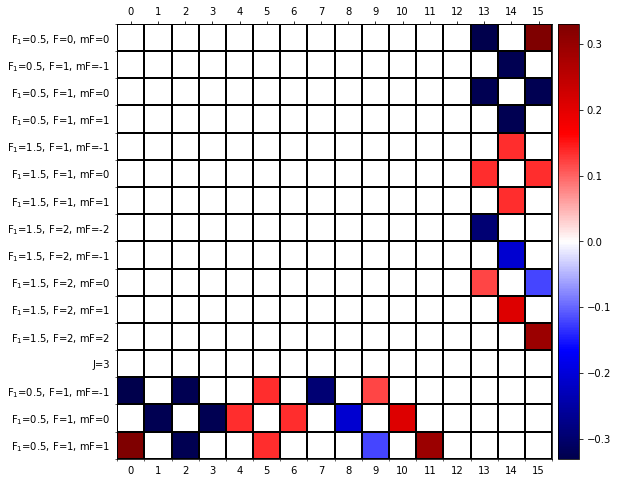

In [34]:
tmp = obe_system.couplings[0]['fields'][0]['field']
tmp[tmp == 0] = np.nan
tmp = np.delete(tmp, np.s_[13:40], axis = 0)
tmp = np.delete(tmp, np.s_[13:40], axis = 1)

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(tmp.real, cmap = cmap)
fig.colorbar(cax, fraction=0.046, pad=0.01)

ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                 bottom=False, top=True, left=False, right=False)

ax.set_xticks(np.arange(0, 16, 1))
ax.set_yticks(np.arange(0, 16, 1))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(-.5, 16, 1), minor=True)
ax.set_yticks(np.arange(-.5, 16, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2);

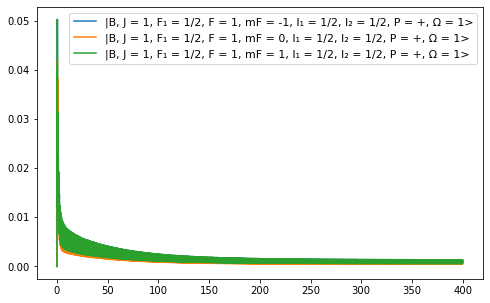

In [35]:
indices_excited = syspars.excited.get_indices(obe_system.QN)
fig, ax = plt.subplots(figsize = (8,5))
for idx in indices_excited:
    ax.plot(t_array*1e6, results[idx], label = obe_system.QN[idx].find_largest_component());

ax.legend(fontsize = 11)

In [ ]:
odepars.ωphase = 0

In [ ]:
t_array, results = centrex.lindblad.do_simulation_single(odepars, (0,200e-6), ρ)

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array*1e6, results.T);
ax.grid(True)

In [ ]:
indices_excited = syspars.excited.get_indices(obe_system.QN)
fig, ax = plt.subplots(figsize = (8,5))
for idx in indices_excited:
    ax.plot(t_array*1e6, results[idx], label = obe_system.QN[idx].find_largest_component());

ax.legend(fontsize = 11)
ax.grid(True)

In [ ]:
odepars.Ωl0 = 0.1*syspars.Γ
odepars.ωp = 1*syspars.Γ
odepars.ωphase = 1*syspars.Γ
odepars.φp = 0.

In [ ]:
t_array, results = centrex.lindblad.do_simulation_single(odepars, (0,200e-6), ρ)

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array*1e6, results.T);
ax.grid(True);

In [ ]:
fig, ax = plt.subplots(figsize = (16,10))
for idx in syspars.ground[0].get_indices(obe_system.QN):
    s = obe_system.QN[idx].find_largest_component()
    l = f"|X, J=1, F1={s.F1}, F={s.F}, mF={s.mF}"
    ax.plot(t_array*1e6, results[idx], label = l);

ax.legend(fontsize = 13)
ax.grid(True)

In [ ]:
indices_excited = syspars.excited.get_indices(obe_system.QN)
fig, ax = plt.subplots(figsize = (8,5))
for idx in indices_excited:
    ax.plot(t_array*1e6, results[idx], label = obe_system.QN[idx].find_largest_component());

ax.legend(fontsize = 11)

In [ ]:
np.trapz(results[syspars.excited.get_indices(obe_system.QN)].sum(axis = 0), x = t_array)*syspars.Γ

## Scanning over 3 parameters, Rabi rate, polarization switching frequency and phase modulation frequency

In [ ]:
parameters = ['Ωl0', 'ωp', 'ωphase']
values = [np.linspace(0.1,1,10)*syspars.Γ, np.linspace(0,2,101)*syspars.Γ, np.linspace(0,2,101)*syspars.Γ]

In [ ]:
output_func = centrex.lindblad.setup_state_integral_calculation(
    syspars.excited.get_indices(obe_system.QN, mode = 'julia'), nphotons = True
)
ens_prob = centrex.lindblad.setup_problem_parameter_scan(odepars, tspan = (0,100e-6), ρ = ρ, parameters = parameters, values = values, dimensions = 3, output_func = output_func)
centrex.lindblad.solve_problem_parameter_scan_progress(output_func = output_func, save_everystep = False, saveat = 1e-8, ensemble_problem_name = ens_prob)

In [ ]:
results = centrex.lindblad.get_results_parameter_scan()

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(results)

In [ ]:
odePar = odepars
pars = str(odePar.p).strip('[]').split(',')

for idN, parameter in enumerate(parameters):
    if isinstance(parameter, (list, tuple)):
        indices = [odePar.get_index_parameter(par) for par in parameter]
    else:
        indices = [odePar.get_index_parameter(parameter)]
    for idx in indices:
        pars[idx] = f"params[i,{idN+1}]"
pars = "[" + ",".join(pars) + "]"
params = np.array(np.meshgrid(*values)).T.reshape(-1,len(values))

In [ ]:
levels = np.linspace(results.min(),results.max(),15)
for val in np.unique(values[0]):
    m = params[:,0] == val
    _r = results[m].copy()
    idxmax = np.argmax(_r)
    print(f"{params[m][idxmax]/syspars.Γ} -> {_r[idxmax]:.2f} photons")
    fig, ax = plt.subplots(figsize = (10,8))
    contour = ax.tricontourf(params[:,1][m]/syspars.Γ, params[:,2][m]/syspars.Γ, results[m], levels = levels)
    fig.colorbar(contour)
    ax.set_xlabel("ωp [Γ]")
    ax.set_ylabel("ωphase [Γ]")

## Scanning the Rabi rate and polarization switching frequency

In [ ]:
parameters = ['Ωl0', 'ωp']
odepars.ωphase = 0.
values = [np.linspace(0,2,101)*syspars.Γ]*2

In [ ]:
output_func = centrex.lindblad.setup_state_integral_calculation(
    syspars.excited.get_indices(obe_system.QN, mode = 'julia'), nphotons = True
)
ens_prob = centrex.lindblad.setup_problem_parameter_scan(odepars, tspan = (0,100e-6), ρ = ρ, parameters = parameters, values = values, dimensions = 3, output_func = output_func)
centrex.lindblad.solve_problem_parameter_scan_progress(output_func = output_func, save_everystep = False, saveat = 1e-8, ensemble_problem_name = ens_prob)

In [ ]:
results = centrex.lindblad.get_results_parameter_scan()

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(results)

### Two different methods to do the 2D plot, one is a contour, the other an interpolation

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
contour = ax.tricontourf(params[:,0]/syspars.Γ, params[:,1]/syspars.Γ, results, levels = 15)
fig.colorbar(contour)

ax.set_xlabel("Ωl0 [Γ]")
ax.set_ylabel("ωp [Γ]")

In [ ]:
X,Y, results = centrex.lindblad.get_results_parameter_scan(scan_values = values)

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
pmesh = ax.pcolormesh(X,Y,results)

fig.colorbar(pmesh)

ax.set_xlabel("Ωl0 [Γ]")
ax.set_ylabel("ωp [Γ]")

In [ ]:
xcoupling = obe_system.couplings[0]['fields'][0]['field']
zcoupling = obe_system.couplings[0]['fields'][1]['field']

In [ ]:
abstol = 5e-2
x_eigval, x_eigvec = np.linalg.eig(xcoupling)
z_eigval, z_eigvec = np.linalg.eig(zcoupling)
x_eigvec[np.abs(x_eigvec) < abstol] = 0
z_eigvec[np.abs(z_eigvec) < abstol] = 0

In [ ]:
labels = [f"F$_1$={qn.F1}, F={int(qn.F)}, mF={int(qn.mF)}" if qn.J != 3 else "J=3" for qn in [qn.find_largest_component() for qn in  obe_system.QN]]

In [ ]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap("plasma")

tmp = x_eigvec.copy()
tmp[tmp == 0] = np.nan
tmp = np.delete(tmp, np.s_[13:40], axis = 0)
tmp = np.delete(tmp, np.s_[16:43], axis = 1)

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(np.abs(tmp), cmap = cmap, vmin = 0, vmax = 1)
fig.colorbar(cax, fraction=0.046, pad=0.01)

ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                 bottom=False, top=True, left=False, right=False)

ax.set_xticks(np.arange(0, 16, 1))
ax.set_yticks(np.arange(0, 16, 1))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(-.5, 16, 1), minor=True)
ax.set_yticks(np.arange(-.5, 16, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2);

In [ ]:
np.linalg.norm(x_eigvec, axis = 0)[:16]

In [ ]:
tmp = z_eigvec.copy()
tmp[tmp == 0] = np.nan
tmp = np.delete(tmp, np.s_[13:40], axis = 0)
tmp = np.delete(tmp, np.s_[16:43], axis = 1)

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(np.abs(tmp), cmap = cmap, vmin = 0, vmax = 1)
fig.colorbar(cax, fraction=0.046, pad=0.01)

ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                 bottom=False, top=True, left=False, right=False)

ax.set_xticks(np.arange(0, 16, 1))
ax.set_yticks(np.arange(0, 16, 1))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(-.5, 16, 1), minor=True)
ax.set_yticks(np.arange(-.5, 16, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2);

In [ ]:
np.linalg.norm(z_eigvec, axis = 0)[:16]

In [ ]:
tmp = obe_system.couplings[0]['fields'][0]['field']
tmp[tmp == 0] = np.nan
tmp = np.delete(tmp, np.s_[13:40], axis = 0)
tmp = np.delete(tmp, np.s_[13:40], axis = 1)

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(np.abs(tmp), cmap = cmap)
fig.colorbar(cax, fraction=0.046, pad=0.01)

ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                 bottom=False, top=True, left=False, right=False)

ax.set_xticks(np.arange(0, 16, 1))
ax.set_yticks(np.arange(0, 16, 1))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(-.5, 16, 1), minor=True)
ax.set_yticks(np.arange(-.5, 16, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2);

In [ ]:
tmp = obe_system.couplings[0]['fields'][1]['field']
tmp[tmp == 0] = np.nan
tmp = np.delete(tmp, np.s_[13:40], axis = 0)
tmp = np.delete(tmp, np.s_[13:40], axis = 1)

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.imshow(np.abs(tmp), cmap = cmap)
fig.colorbar(cax, fraction=0.046, pad=0.01)

ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False,
                 bottom=False, top=True, left=False, right=False)

ax.set_xticks(np.arange(0, 16, 1))
ax.set_yticks(np.arange(0, 16, 1))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(-.5, 16, 1), minor=True)
ax.set_yticks(np.arange(-.5, 16, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2);

In [ ]:
x_darkstates = [i for i,v in enumerate(x_eigvec.T[:15]) if np.abs(v[-3:]).sum() == 0]
z_darkstates = [i for i,v in enumerate(z_eigvec.T[:15]) if np.abs(v[-3:]).sum() == 0]
print(x_darkstates)
print(z_darkstates)

In [ ]:
max_overlaps = {}
for idz, z in enumerate(z_eigvec.T[:15]):
    if np.abs(z[-3:]).sum() == 0:
        idx_overlap, overlap = 0,0
        for i,x in enumerate(x_eigvec.T[:15]):
            v = np.abs(z@x)
            if v > overlap:
                idx_overlap = i
                overlap = v
        max_overlaps[idz] = (idx_overlap, overlap)

In [ ]:
max_overlaps

In [ ]:
idx = 11
print(obe_system.QN_original[idx].find_largest_component())
print(np.linalg.norm(z_eigvec[idx,:]))
z_eigvec[idx,:].real

In [ ]:
idx = 10
print(obe_system.QN_original[idx].find_largest_component())
print(np.linalg.norm(x_eigvec[idx,:]))
np.abs(x_eigvec[idx,:])

In [ ]:
xmax = np.argmax(np.abs(x_eigvec), axis = 1)
zmax = np.argmax(z_eigvec.real, axis = 1)
for i, (idx, idz) in enumerate(zip(xmax, zmax)):
    xtrue = np.any([v in [40,41,42] for v in np.nonzero(x_eigvec[:,idx])[0]])
    ztrue = np.any([v in [40,41,42] for v in np.nonzero(z_eigvec[:,idz])[0]])
    if (not xtrue) and (not ztrue):
#         print(i,np.abs(x_eigvec[i,idx]),np.abs(z_eigvec[i,idz]))
        lc = obe_system.QN_original[i].find_largest_component()
        if lc.J == 3 or lc.electronic_state == 'B':
            continue
        print(lc)
        print(f"i = {i}, x coupling : {np.abs(x_eigvec[i,idx]):.3f}, z coupling : {np.abs(z_eigvec[i,idz]):.3f}") 
        print("="*50)

In [ ]:
def check_symmetric(a, rtol=1e-08, atol=1e-12):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)
check_symmetric(xcoupling)

In [ ]:
reltol = 1e-5
tmp = []

for vec in z_eigvec.T:
    indices = np.where(np.abs(vec) >= reltol)[0]
    tmp.append(dict((idx, vec[idx]) for idx in indices))

In [ ]:
indices_nonzero = [list(v.keys()) for v in tmp ]
indices_nonzero[:15]

In [ ]:
obe_system.QN_original[11].find_largest_component()

In [ ]:
zcoupling[7,:]

In [ ]:
plt.imshow(zcoupling.real[-3:,:15])

In [ ]:
obe_system.QN_original[5].find_largest_component()